# Sparse GP Classification

## Model Description

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim\mathcal{SPGP}(K, z_{1:M})$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_n \sim \mathrm{Bernoulli}(\sigma(f))$,

where $K(x_1,x_2) = \exp\left(\beta - \sum_{d=1,2}\mathrm{softplus}({\alpha_d})\cdot(x_{1d} - x_{2d})^2\right)$.
<br>
Here, latent process $f\sim\mathcal{SPGP}(K, z_{1:M})$ is defined as:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$u=f_0\small{(z_{1:M})}$ for $f_0\sim\mathcal{GP}(K)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f(x)\sim\mathcal{GP}(K| f\small{(z_{1:M})}=u)$ <br>
Additionally, conditional independence of process $f$ among any points given $u=f_0\small{(z_{1:M})} = \left(f_0(z_1), ..., f_0(z_M)\right)$ is assumed. <br>
That is, for any $n_1$ and $n_2$, $f(x_{n_1})\perp \!\!\! \perp f(x_{n_1})|u$.

## Local Marginalization of Evidece Lower Bound
By simplifying notation as $f_{1:N} = f(x_{1:N})$ and $u = f(z_{1:M})$, we can write evidence lower bound (ELBO) and locally margianlized likelihood (LM-ELBO).

\begin{align}
\mathrm{LM}\text{-}\mathrm{ELBO}
&= \log p(y_{1:N}) - \mathrm{KL}\left[\ q(u)\ ||\ p(u|y_{1:N})\ \right] \\
&= \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&\geq \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)
- \mathrm{KL}\left[\ p(f_{1:N}|u)\ ||\ p(f_{1:N}| y_{1:N}, u)\ \right]\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \log p(y_{1:N}) - \mathrm{KL}\left[ p(f_{1:N}|u)q(u) || p(y_{1:N}, f_{1:N}, u) \right]\\
&= \mathrm{E}_{u\sim q} \mathrm{E}_{f_{1:N}\sim p(f_{1:N}|u)}\left[
\log \left(\frac{p(y_{1:N}, f_{1:N}, u)}{p(f_{1:N}| u)q(u)}\right) 
\right] \\
&= \sum_{n=1}^N\mathrm{E}_{u\sim q} \mathrm{E}_{f_n\sim p(f_n|u)}
\left[ \log p(y_n| f_n) \right] 
- \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \mathrm{ELBO}
\end{align}

### Possible Datasets
- http://archive.ics.uci.edu/ml/datasets/Adult
- http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking
- http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
- http://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+

## Import Packages

In [144]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [145]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
import matplotlib
from matplotlib import pyplot as plt
import time
import datetime
np.random.seed(0)

In [146]:
tf.test.is_gpu_available()

False

## Utilities

In [147]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Generate Toy Dataset

In [148]:
N = 1000
D = 2

In [149]:
# Paramters
b0 = np.float64(0.)
b  = np.random.randn(D) / np.sqrt(D)

In [150]:
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, b0, b):
    """
    Genarate N samples of data from the model with parameter [beta0, beta, alpha]. 
    Returns:
    x: 3-d array of size [N, D]
    y: 2-d array of size [N]
    """
    x = np.random.randn(N*D).reshape([N,D])
    logit = lambda x: b0+x@b
    y = bernoulli(p=sigmoid(logit(x))).rvs()
    likelihood = np.sum(y*np.log(sigmoid(logit(x))) + (1-y)*np.log(1-sigmoid(logit(x))))
    print('test_likelihood: {}'.format( likelihood ) )
    return x,y, logit

In [151]:
x,y,logit = generate_data(N, D, b0, b)

test_likelihood: -560.6633839821673


In [152]:
M = 30
theta = {
    'z': tf.Variable(2.*np.random.randn(M*D).reshape([M,D])),
    'alpha': tf.Variable(np.ones([D]), dtype=tf.float64),
    'beta': tf.Variable(1., dtype=tf.float64)
}
phi = {
    'm': tf.Variable(np.zeros([M]), dtype=tf.float64),
    'S': tf.Variable(np.eye(M), dtype=tf.float64)
}

In [153]:
def get_K(alpha, beta):
    # define Kernel
    D = alpha.shape[0]
    sp_alpha = tf.reshape( tf.math.softplus( alpha ), [1,1,D])
    def K(x1,x2):
        n1 = x1.shape[0]
        n2 = x2.shape[0]
        x1 = tf.reshape(x1, [n1, 1, 2])
        x2 = tf.reshape(x2, [1 ,n2, 2])
        return tf.exp(beta - tf.reduce_sum( sp_alpha*(x1-x2)**2, axis=2))
    return K

## ELBO

In [154]:
def ELBO(x, y, theta, phi, N_total):
    '''
    Inputs:
    x: 2-d array of shape [N,D]
    y: 1-d array of shape [N]
    theta: disctionary of model parameters
    phi: disctionary of variational parameters
    
    Returns:
    elbo: scalar
    '''
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample()

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    elbo = tf.reduce_mean(p_y.log_prob(y)) - kl_qu_pu / N_total
    return elbo

In [170]:
def LMELBO(x, y, theta, phi, N_total, n_MC):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    f = q_f.sample(n_MC)

    # compute LMELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    log_prob_y = tf.reduce_mean( tf_logmeanexp( p_y.log_prob(y) , axis=0) ) 
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
    lmelbo = log_prob_y - kl_qu_pu / N_total
    return lmelbo

In [156]:
def pointwise_dconditional_likelihood(x, y, theta, phi, level):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # sample u = f_0(z_1,...,z_M) from q
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    u = q_u.sample(N)
    
    # sample f conditionally given u = f_0(z_1,...,z_M)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)

    # compute ELBO estimate
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    if level==0:
        return tf_logmeanexp(w, axis=0) 
    else:
        return tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)

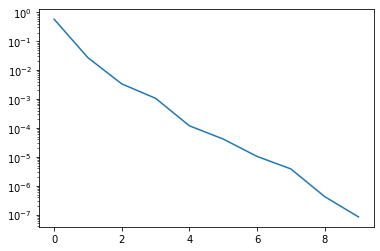

In [206]:
get_var = lambda l: pointwise_dconditional_likelihood(x, y, theta, phi, level=l).numpy().var()
plt.plot([get_var(l) for l in range(10)])
plt.yscale('log')

In [158]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=1).numpy().var()

0.03126870259468976

In [159]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=2).numpy().var()

0.0041383015103111515

In [160]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=3).numpy().var()

0.0013936474982571894

In [161]:
pointwise_dconditional_likelihood(x, y, theta, phi, level=4).numpy().var()

0.00012949616413605766

In [162]:
def dconditional_likelihood(x, y, mean_f, var_f, level):
    
    N = y.shape[0]
    # sample f_n's
    q_f = tfp.distributions.Normal(loc=mean_f, scale=var_f)
    n_MC = 2**level
    f = q_f.sample(n_MC)
    
    # sample conditional likelihoods
    p_y = tfp.distributions.Bernoulli(logits=f)
    w = p_y.log_prob(y)
    w = tf.reshape(w, [n_MC,N])
    
    if level==0:
        dL = tf_logmeanexp(w, axis=0) 
    else:
        dL = tf_logmeanexp(w, axis=0)\
                - (1/2.) * tf_logmeanexp(w[:n_MC//2 ], axis=0)\
                - (1/2.) * tf_logmeanexp(w[ n_MC//2:], axis=0)
    return tf.reduce_mean( dL )

In [163]:
def LMELBO_MLMC(x, y, theta, phi, N_total, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    max_level: integer
    w0: the proportion of total samples in (x,y) used at the level 0.
        in other words, 100*(1-w0) % of the total samples are used for estimating the correction term.
    b: scalar. the second moment of the coupled difference estimator (dIWELBO) must decrease at a rate of O(2^(-b*level)).
    randomize: whether to use randomization of MLMC.
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    # unpack parameters
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    
    N = y.shape[0]
    M = z.shape[0]
    
    m = phi['m']
    S = phi['S'] + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholS = tf.linalg.cholesky(S)
    
    # calculate KL divergence of p(u) and q(u) of u = f_0(z_1,...,z_M)
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    
    p_u = tfp.distributions.MultivariateNormalTriL(loc=0., scale_tril=CholK_mm)
    q_u = tfp.distributions.MultivariateNormalTriL(loc=m, scale_tril=CholS)
    kl_qu_pu = tfp.distributions.kl_divergence(q_u, p_u)
      
    # calculate distribution of f conditionally on u = f_0(z_1,...,z_M)
    u = q_u.sample(N)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,nj->n', K_nm, inv_K_mm, u)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    # determine proportions of the number of smaples among levels
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    
    # determine the N_l's
    if randomize==True:
        Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    # compute dIWELBO's using disjoint samples at each level and sum them up
    offset = 0
    lmelbo = kl_qu_pu / N_total
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[offset:offset+Ns[i]]
        y_tmp = y[offset:offset+Ns[i]]
        mean_f_tmp = mean_f[offset:offset+Ns[i]]
        var_f_tmp = var_f[offset:offset+Ns[i]]
                       
        if randomize==True:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            lmelbo += dconditional_likelihood(x_tmp, y_tmp, mean_f_tmp, var_f_tmp, level=l)
    
        offset += Ns[i]
          
    return lmelbo

In [164]:
ELBO(x, y, theta, phi, 10000)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.901020819650497>

In [221]:
LMELBO(x, y, theta, phi, 10000, n_MC=2**10)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8438692044035605>

In [218]:
LMELBO_MLMC(x, y, theta, phi, N_total=10000, max_level=10, w0=1-2.**(-3/2), b=2, randomize=False)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8029116955270268>

## Parameter Estimation

In [49]:
def apply_grad(param, dparam, learning_rate):
    for p, dp in zip(param.values(), dparam.values()):
        p.assign_add(learning_rate * dp)

In [50]:
def apply_natgrad_phi(phi, deta, learning_rate):
    m = phi['m']
    S = phi['S']
    deta_m = deta['m']
    deta_S = deta['S']
    phi['m'].assign_add(learning_rate * tf.einsum('ni,i->n',S,deta_m))
    phi['S'].assign_add(learning_rate * S@deta_S@S)

In [51]:
phi_to_eta = lambda phi: {
    'm': phi['m'],
    'S': tf.einsum('i,j->ij', phi['m'], phi['m']) + phi['S']
}
eta_to_phi = lambda eta: {
            'm': eta['m'],
            'S': eta['S'] - tf.einsum('i,j->ij', eta['m'], eta['m'])
}

In [67]:
for t in range(1000):
    rho_t = 10/(10+t)**0.7
    
    with tf.GradientTape() as g:
        eta = phi_to_eta(phi)
        g.watch([theta, eta])
        phi_tmp = eta_to_phi(eta)
        lmelbo = LMELBO(x, y, theta, phi_tmp, n_MC=10)
    dtheta, deta = g.gradient(lmelbo, [theta, eta])
    
    apply_grad(theta, dtheta, rho_t)
    apply_natgrad_phi(phi, deta, rho_t)
    
    if t%20==0:
        print('#iter: {}\t{}'.format(t, lmelbo.numpy()))

#iter: 0	-599.3167285009555
#iter: 20	-596.3427775834537
#iter: 40	-603.8747974515564
#iter: 60	-593.5232744364357
#iter: 80	-595.1759263598262
#iter: 100	-592.170186114221
#iter: 120	-594.96390174708
#iter: 140	-587.0179151632208
#iter: 160	-591.8284663629383
#iter: 180	-601.2980219786311
#iter: 200	-592.8169245706313
#iter: 220	-592.02140801903
#iter: 240	-597.9149655230425
#iter: 260	-604.2983377092937
#iter: 280	-597.4702607026721
#iter: 300	-587.6159067373495
#iter: 320	-590.761479947319
#iter: 340	-608.3326405899463
#iter: 360	-584.0611601590609
#iter: 380	-589.2489495774226
#iter: 400	-592.1154299144698
#iter: 420	-590.9475840693109
#iter: 440	-593.6364162912218
#iter: 460	-596.8169698733567
#iter: 480	-587.6703645613358
#iter: 500	-604.2846950350487
#iter: 520	-595.1472798077003
#iter: 540	-593.5570482408993
#iter: 560	-594.2744375230079
#iter: 580	-590.9963358440752
#iter: 600	-593.807442863517
#iter: 620	-584.0488757204727
#iter: 640	-599.9984482362213
#iter: 660	-596.4256614

In [17]:
for t in range(1000):
    rho_t = 10/(10+t)**0.7
    
    with tf.GradientTape() as g:
        eta = phi_to_eta(phi)
        g.watch([theta, eta])
        phi_tmp = eta_to_phi(eta)
        elbo = ELBO(x, y, theta, phi_tmp)
    dtheta, deta = g.gradient(elbo, [theta, eta])
    
    apply_grad(theta, dtheta, rho_t)
    apply_natgrad_phi(phi, deta, rho_t)
    
    if t%20==0:
        print('#iter: {}\t{}'.format(t, elbo.numpy()))

#iter: 0	-890.8624765026154
#iter: 20	-697.8474758725588
#iter: 40	-665.919811764245
#iter: 60	-657.3072190558822
#iter: 80	-662.1433414510145
#iter: 100	-667.5221570997699
#iter: 120	-639.7643349423189
#iter: 140	-638.9777205587757
#iter: 160	-645.0049310390618
#iter: 180	-643.3594486077355
#iter: 200	-627.0965103636099
#iter: 220	-628.1768501878715
#iter: 240	-615.8963230770331
#iter: 260	-632.7243975856217
#iter: 280	-641.0877760231249
#iter: 300	-626.4418771867704
#iter: 320	-619.4794970808142
#iter: 340	-624.5115608854521
#iter: 360	-625.5142580741636
#iter: 380	-607.8812043772948
#iter: 400	-628.6381653396292
#iter: 420	-607.8471703727811
#iter: 440	-640.1321093605526
#iter: 460	-638.2483232931978
#iter: 480	-625.9379517414916
#iter: 500	-615.162652231652
#iter: 520	-634.6126625663886
#iter: 540	-627.1681618615042
#iter: 560	-623.0588398487761
#iter: 580	-619.9994226416111
#iter: 600	-611.5802187291014
#iter: 620	-625.134025580645
#iter: 640	-610.713602660471
#iter: 660	-608.8578

## Visualize Prediction

In [68]:
def get_logits(x, theta, phi):
    
    z = theta['z']
    alpha = theta['alpha']
    beta = theta['beta']
    K = get_K(alpha, beta)
    m = phi['m']
    S = phi['S']
    CholS = tf.linalg.cholesky(S)
    
    N = x.shape[0]
    M = z.shape[0]
    
    K_mm = K(z, z) + 1e-6 * tf.eye(M, dtype=tf.float64)
    CholK_mm = tf.linalg.cholesky(K_mm)
    inv_CholK_mm = tf.linalg.inv(CholK_mm)
    inv_K_mm = tf.transpose(inv_CholK_mm)@inv_CholK_mm
    K_nm = K(x, z)
    K_mn = tf.transpose(K_nm)
    
    mean_f = tf.linalg.einsum('ni,ij,j->n', K_nm, inv_K_mm, m)
    var_f = tf.vectorized_map(lambda x:K(x,x), tf.expand_dims(x, axis=1))
    var_f = tf.reshape(var_f, [N])
    var_f = var_f - tf.linalg.einsum('ni,ij,jn->n', K_nm, inv_K_mm, K_mn)
    
    return mean_f, var_f

In [69]:
x1_heat = (np.linspace(start=-4,stop=4).reshape([1,50])*np.ones([50,1])).reshape([2500])
x2_heat = np.repeat(np.linspace(start=-4,stop=4), 50)
x_heat = np.array([x1_heat, x2_heat]).T
logits_heat = get_logits(x_heat, theta, phi)[0].numpy()

In [70]:
def heatmap2d(arr: np.ndarray, cmap='viridis'):
    plt.imshow(arr, cmap=cmap, extent=[-4,4,-4,4],origin='lower', alpha=1, vmin=0, vmax=1)
    plt.colorbar()
    #plt.show()

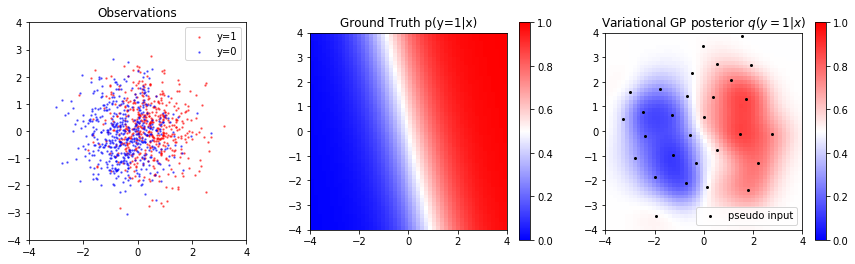

In [71]:
plt.figure(figsize=[15,4])
cmap = matplotlib.cm.get_cmap('bwr')#('viridis')

plt.subplot(1,3,1)
plt.title('Observations')
idx = (y==True)
plt.scatter(x[idx,0], x[idx,1], s=2, alpha=0.5, marker='o', c=[cmap(1.)])
plt.scatter(x[~idx,0], x[~idx,1], s=2, alpha=0.5, marker='o', c=[cmap(0.)])
plt.legend(['y=1','y=0'])
plt.xlim([-4,4])
plt.ylim([-4,4])
ax = plt.gca()
ax.set_aspect('equal')

plt.subplot(1,3,2)
plt.title('Ground Truth p(y=1|x)')
heatmap2d(sigmoid(logit(x_heat)).reshape([50,50]), 'bwr')

plt.subplot(1,3,3)
plt.title(r'Variational GP posterior $q(y=1|x)$')
#plt.scatter(x[idx,0], x[idx,1], s=0.3, alpha=1, marker='x', c=[cmap(1.)])
#plt.scatter(x[~idx,0], x[~idx,1], s=0.3, alpha=1, marker='x', c=[cmap(0.)])
a = plt.scatter(theta['z'][:,0], theta['z'][:,1], s=4, alpha=1, marker='o', c='black')
plt.legend([a],['pseudo input'])
heatmap2d(sigmoid(logits_heat.reshape([50,50])), 'bwr')

## IW-ELBO approximation of Evidence

Importance weighted evidence lower bound (IW-ELBO) is an approximation of the evidence, and its Monte Carlo estimator is defined as:
$$\mathrm{IW}\text{-}\mathrm{ELBO}(x,z_{1:K}):=\frac{1}{N}\sum_{n=1}^{N}\log \frac{1}{K}\sum_{k=1}^{K}\left(\frac{p(x_n,z_{nk})}{q(z_{nk};x_n)}\right),$$
where $z_{nk}$ is sampled as $z_{nk}\sim q(z;x_n)$.

In [22]:
def pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    """
    Compute IWELBOs using n_MC inner Monte Carlo samples of Z's at each sample point. 
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
     
    Returns:
    iwelbos: 1-d array of size [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = as_tf_float( tf.reshape(y, [1,N,T]) )
    mu = tf.reshape(mu, [1,N])
    sigma = tf.reshape(sigma, [1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.math.softplus(alpha)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbos = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbos

In [23]:
def IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC):
    """
    Compute IWELBO
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
     
    Returns:
    iwelbo: scalar value of average of iwelbo's at each sample point.
    """

    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return iwelbo

## MLMC

In [24]:
def pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    """
    Compute the coupled differences of IWELBO's at each sample point.
    Differences between "IWELBO with n_MC inner Monte Carlo samples" 
    and "IWELBO with n_MC/2 inner Monte Carlo samples" are taken.
    
    Note that difference is not taken when n_MC = 1. 
    In that case, IWELBO with n_MC = 1 is Evaluated.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of [N]
    sigma: 1-d array of [N]
     
    Returns:
    scores: 1-d array of size [N]
    """
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, alpha, mu, sigma)
    return scores

In [25]:
def dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level):
    """
    Compute average of the coupled differences of IWELBO's with n_MC.
    Differences between "IWELBO with n_MC inner Monte Carlo samples" 
    and "IWELBO with n_MC/2 inner Monte Carlo samples" are taken.
    
    Note that difference is not taken when n_MC = 1. 
    In that case, average IWELBO with n_MC = 1 is Evaluated.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
     
    Returns:
    score: scalar value of average of differnece of iwelbo's at each sample point (except when n_MC=1).
    """

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    score = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return score

In [26]:
def IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    max_level: integer
    w0: the proportion of total samples in (x,y) used at the level 0.
        in other words, 100*(1-w0) % of the total samples are used for estimating the correction term.
    b: scalar. the second moment of the coupled difference estimator (dIWELBO) must decrease at a rate of O(2^(-b*level)).
    randomize: whether to use randomization of MLMC.
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    
    N, T, D = x.shape
    
    # determine proportions of the number of smaples among levels
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    
    # determine the N_l's
    if randomize==True:
        Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    # compute dIWELBO's using disjoint samples at each level and sum them up
    offset = 0
    iwelbo = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[offset:offset+Ns[i]]
        y_tmp = y[offset:offset+Ns[i]]
        mu_tmp = mu[offset:offset+Ns[i]]
        sigma_tmp = sigma[offset:offset+Ns[i]]
                       
        if randomize==True:
            iwelbo += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            iwelbo += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l)
        
        offset += Ns[i]
    
    return iwelbo

## SUMO

#### Variance Analysis of SUMO:
We assume that $\mathbb{P}(k\leq\mathcal{K})=\frac{1}{k}$ for $\mathcal{K}\leq K_{\text{max}}$, and accordingly, $\mathbb{P}(k\leq\mathcal{K})=\frac{1}{k(k+1)}$. Also, we know convergence rate of $\Delta_k:=\mathrm{IWELBO(x,z_{1:k})} - \mathrm{IWELBO(x,z_{1:k-1})}$ is as following:

- $\mathrm{E}|\Delta_k| = \mathcal{O}(1/k)$
- $\mathrm{E}|\Delta_k|^2 = \mathcal{O}(1/k^2) \geq \mathrm{Var}[\Delta_k]$
- $\mathrm{E}[\Delta_k] = \mathcal{O}(1/k^2)$　　　←（∵$\sum_{k=K}^{\infty}\mathrm{E}[\Delta_k] = \mathcal{O}(\frac{1}{K})$）

Using above properties, we can analyze the order of magnitude of the variance of SUMO as:
\begin{align}
\mathrm{Var}[\Delta SUMO]
&= \mathrm{Var}_{\mathcal{K}, \Delta_{1:K_{\text{max}}}} 
\left( \sum_{k=1}^{K_{\text{max}}} \frac { \mathbb{1}_{(k\leq\mathcal{K})} } 
{ \mathbb{P}(k\leq\mathcal{K}) } \Delta_k \right) \\
&= \mathrm{E}_{\mathcal{K}}\mathrm{Var}_{\Delta_{1:K_{\text{max}}}}
\left( \sum_{k=1}^{\mathcal{K}} k \Delta_k | \mathcal {K}\right)
 + \mathrm{Var}_{\mathcal{K}}\mathrm{E}_{\Delta_{1:K_{\text{max}}}}
\left( \sum_{k=1}^{\mathcal{K}} k \Delta_k | \mathcal {K}\right) \\
&= \mathrm{E}_{\mathcal{K}}\sum_{k=1}^{\mathcal{K}} k^2 \mathrm{Var}_{\Delta_{1:K_{\text{max}}}}
\left( \Delta_k | \mathcal {K}\right)
 + \mathrm{Var}_{\mathcal{K}} \sum_{k=1}^{\mathcal{K}} k \mathrm{E}_{\Delta_{1:K_{\text{max}}}}
\left( \Delta_k | \mathcal {K}\right) \\
&= \mathrm{E}_{\mathcal{K}}\sum_{k=1}^{\mathcal{K}} k^2 \mathcal{O}(1/k^2)
 + \mathrm{Var}_{\mathcal{K}} \sum_{k=1}^{\mathcal{K}} k \mathcal{O}(1/k^2) \\
&= \mathrm{E}_{\mathcal{K}} \mathcal{O}(\mathcal{K})
 + \mathrm{Var}_{\mathcal{K}}\mathcal{O}(\log \mathcal{K}) \\
&= \mathcal{O}(\log K_{\text{max}}) + \text{const.}
\end{align}

Note that the expected complexity of SUMO is $\mathrm{E}[\mathcal{\mathcal{K}}] = \mathcal{O}(\log K_{\text{max}})$. Therefore, the "variance per reciprocal complexity" for SUMO is $\mathcal{O}\left((\log K_{\text{max}})^2\right)$. Those for NMC and MLMC are $\mathcal{O}(K_{\text{max}})$ and $\mathcal{O}(1)$ respectively.

In [27]:
def conditional_IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K):
    """
    Compute IWELBO by SUMO for one sample point, given K
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    K: integer 
    
    Returns:
    iwelbo: scalar estimate of iwelbo at the given sample point.
    """
    N,T,D = x.shape
    z = tf.random.normal(mean=mu, stddev=sigma, shape=[K,N], dtype=tf.float64)

    # compute prob ratio of shape [K,N]
    y_logit = beta0 + tf.reshape( x @ tf.reshape(beta,[D,1]), [1,N,T] ) + tf.reshape(z,[K,N,1]) 
    p_y = tfp.distributions.Bernoulli(logits=y_logit)
    p_z = tfp.distributions.Normal(loc=0, scale=tf.math.softplus(alpha)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    # compute SUMO est.
    ks = tf.reshape( tf.cast( tf.range(0,K) + 1, tf.float64), [K,1])
    cum_iwelbo = tf.math.cumulative_logsumexp(log_prob_ratio, axis=0) - tf.math.log(ks)
    inv_weights = ks
    iwelbo = cum_iwelbo[0,:] + tf.reduce_sum(inv_weights[1:] * (cum_iwelbo[1:] - cum_iwelbo[:K-1]), axis=0)
    
    return iwelbo

In [28]:
def IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=64):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    K_max: integer 
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    
    N,T,D = x.shape
    
    Us = tf.random.uniform(shape=[N], dtype=tf.float64)
    Ks = tf.minimum(1/Us, tf.cast(K_max, tf.float64))
    Ks = tf.cast(tf.math.floor(Ks), tf.int64)
    unique, _, counts =  tf.unique_with_counts(tf.sort(Ks))
    
    offset = 0
    iwelbo = 0
    for K, cnt in zip(unique, counts):
        x_tmp = x[offset:offset+cnt]
        y_tmp = y[offset:offset+cnt]
        mu_tmp = mu[offset:offset+cnt]
        sigma_tmp = sigma[offset:offset+cnt]
        iwelbo += (1/N) * tf.reduce_sum( conditional_IWELBO_SUMO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, K) ) 
        offset += cnt
    
    return iwelbo

## Make sure that implementations are consistent

In [29]:
x,y,_ = generate_data(N=10000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    

NameError: name 'beta0' is not defined

In [ ]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, alpha).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64).numpy()
iwelbo_likelihood_mlmc = IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=6, w0=0.9, randomize=False).numpy()
iwelbo_likelihood_randmlmc = IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=6, w0=0.9, randomize=True).numpy()
iwelbo_likelihood_sumo = IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=10000).numpy()

In [ ]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

In [ ]:
iwelbo_likelihood_mlmc, iwelbo_likelihood_randmlmc, iwelbo_likelihood_sumo 

## MLMC codition check for objective

In [ ]:
def conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [ ]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

In [ ]:
# plot results
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']].iloc[0]
plt.plot(t*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [ ]:
# compute cost-variance efficiency of MLMC 
C = [1 if l==0 else 2**(l+1) for l in range(L)]
V = conv_stats['var_dIWELBO']
N = np.sqrt(V/C)
cost_mlmc = [np.sum([np.sqrt(c*v) for c,v in zip(C[:l+1], V[:l+1])])**2  for l in range(L)]
cost_nmc = [2**l * v for l,v in enumerate(conv_stats['var_IWELBO'])]

In [ ]:
plt.figure(figsize=[12,4])
# plot theoretical computational efficiency
plt.subplot(1,2,1)
plt.plot(cost_mlmc)
plt.plot(cost_nmc)
plt.yscale('log')
plt.ylabel('Variance per Reciprocal Complexity')
plt.xlabel('level')
plt.legend(['MLMC', 'Nested MC'])
# plot N_l's for MLMC
plt.subplot(1,2,2)
plt.plot(N)
plt.yscale('log')
plt.ylabel(r'$N_l$')
plt.xlabel('level')
print('(Theoretical) Variance per Reciprocal Complexity and N_l\'s for MLMC')

In [ ]:
conv_stats

## MLMC codition check for gradients

In [ ]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute the gradient of dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T
    
    param = tf.concat([beta, [beta0], [alpha]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    params = tf.reshape(param, [1,D+2]) * np.ones([N,1])

    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)        
    
    # Define a gradient function to be vectorized (vectorization for better performance)
    def get_grad(args):
        # get gradient of dIWELBO (and IWELBO) given one sample
        param, x_, y_, z_, mu, sigma = args
        z_ = tf.reshape(z_, [-1,1])
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[0,:D]
            beta0_ = param[0,D]
            alpha_ = param[0,D+1]
            diwelbos = pointwise_dIWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)
            iwelbos = pointwise_IWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)    
        a = g.gradient(diwelbos, param)
        b = g.gradient(iwelbos, param)
        del g
        return a,b
    
    # Compute the gradient of dIWELBO (and IWELBO) for each sample
    args = [tf.expand_dims(arg, axis=1) for arg in [params, x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
    
    grad_diwelbos = tf.squeeze(grads[0])#[:D+1]
    grad_iwelbos = tf.squeeze(grads[1])#[:D+1]
    
    # return summary statistics of the gradients
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [ ]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

In [ ]:
# plot results
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']].iloc[0]
plt.plot(t*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\Delta \mathrm{IW}$-$\mathrm{ELBO})])$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\mathrm{IW}$-$\mathrm{ELBO})])$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [ ]:
# compute cost-variance efficiency of MLMC 
C = [1 if l==0 else 2**(l+1) for l in range(L)]
V = conv_stats['trace_covariance_grad_dIWELBO']
N = np.sqrt(V/C)
cost_mlmc = [np.sum([np.sqrt(c*v) for c,v in zip(C[:l+1], V[:l+1])])**2  for l in range(L)]
cost_nmc = [2**l * v for l,v in enumerate(conv_stats['trace_covariance_grad_IWELBO'])]

In [ ]:
plt.figure(figsize=[12,4])
# plot theoretical computational efficiency
plt.subplot(1,2,1)
plt.plot(cost_mlmc)
plt.plot(cost_nmc)
plt.yscale('log')
plt.ylabel('Variance per Reciprocal Complexity')
plt.xlabel('level')
plt.legend(['MLMC', 'Nested MC'])
# plot N_l's for MLMC
plt.subplot(1,2,2)
plt.plot(N)
plt.yscale('log')
plt.ylabel(r'$N_l$')
plt.xlabel('level')
print('(Theoretical) Variance per Reciprocal Complexity and N_l\'s for MLMC')

In [ ]:
conv_stats

In [ ]:
def conv_stats_dSUMO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    dsumos = 0
    dsumos += pointwise_IWELBO(x, y, z[ :,:], beta0, beta, alpha, mu, sigma).numpy()
    dsumos -= pointwise_IWELBO(x, y, z[1:,:], beta0, beta, alpha, mu, sigma).numpy()
    
    dN = N//10
    var_sumos = dN * np.var([
        IWELBO_SUMO(
            x[dN*i:dN*(i+1)], y[dN*i:dN*(i+1)], beta0, beta, alpha,
            mu[dN*i:dN*(i+1)], sigma[dN*i:dN*(i+1)], K_max=2**level
            ) 
        for i in range(10)])
    
    return {'mean_dSUMO':np.mean(dsumos), 
            'mean_abs_dSUMO':np.mean(np.abs(dsumos)), 
            'mean_squared_dSUMO':np.mean(dsumos**2),
            'var_dSUMO':np.var(dsumos),
            'var_SUMO':var_sumos}

In [ ]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dSUMO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

In [ ]:
# plot results
plt.plot(conv_stats[['mean_abs_dSUMO', 'var_dSUMO', 'var_SUMO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['mean_abs_dSUMO', 'var_dSUMO']].iloc[1]
plt.plot(s*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E}  |\Delta^{\mathrm{SUMO}}_{2^{\ell}}|$', 
            r'$\mathrm{Var}[\Delta^{\mathrm{SUMO}}_{2^{\ell}}]$', 
            r'$\mathrm{Var}[\mathrm{SUMO}_{2^{\ell}}]$', 
            r'$O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [ ]:
conv_stats

## Cost comparison of objective

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=True),
    'SUMO':     lambda x,y,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}
results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( obj(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        if level>10 and name=='NMC':
            start = time.time()
            obj(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            obj(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel('Variance per Reciprocal Runtime')
plt.yscale('log')

Variance per "reciprocal of the runtime" is considered because the varince is propotional to the  "reciprocal of the runtime". As we increase the computational complexity (runtime), the decrease in varince is inversely propotional to the complexity. 

## Cost comparison of gradients

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.98, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.98, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.95, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.95, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

## Maximum Likelihood by Different Approximation

In [ ]:
def get_mlmc_cost(N, max_level, b, w0):
    # compute the cost of MLMC estimation 
    # when the size of x (and that of y) is N
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    cost = np.ceil(N * weights[0])\
            + N * sum( np.ceil(weights[1:] * (2**levels[1:] + 2**(levels[1:]-1))) )
    return cost

In [ ]:
objectives = {
    "signorm":   lambda x, y, beta0, beta, alpha, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, alpha),
    "elbo":      lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1),
    "iwelbo8":   lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=8),
    "iwelbo64":  lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64),
    "iwelbo512": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=512),
    "iwelbo512_mlmc": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=False),
    "iwelbo512_randmlmc": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=True),
    "iwelbo512_sumo": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=512),

}
N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (200, 2, 3)

n_repeat = 10
params_repeated = {name:[] for name in objectives.keys()}

for name, obj in objectives.items():
    alpha_s = []
    beta0_s = []
    beta_s = []
    for i in range(n_repeat):
        print("training {}.... #iter:{} ".format(name,i))

        beta0_ = tf.Variable(0., dtype=tf.float64)
        beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
        alpha_   = tf.Variable(1., dtype=tf.float64)

        # Gradient Descent
        for t in range(2001):

            rho_t = 0.5/(1+t)**0.7
            x,y,_ = generate_data(N, D, T, beta0, beta, alpha)
            # balance the cost of mlmc and nmc when level=9 (n_MC=512)
            if 'mlmc' in name:
                cost_nmc  = N * 2**9
                cost_mlmc = get_mlmc_cost(N, max_level=9, b=1.8, w0=0.9)
                N_mlmc = np.math.ceil(N * (cost_nmc / cost_mlmc))
                x,y,_ = generate_data(N_mlmc, D, T, beta0, beta, alpha)    

            with tf.GradientTape() as g:
                g.watch([beta0_, beta_, alpha_])
                mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), alpha_.numpy())
                score = obj(x, y, beta0_, beta_, alpha_, mu, sigma)
            dbeta0_, dbeta_, dalpha_ = g.gradient(score, [beta0_, beta_, alpha_])

            beta0_ = beta0_ + rho_t*dbeta0_
            beta_ = beta_ + rho_t*dbeta_
            alpha_ = alpha_ + dalpha_
            if t%200==0 and i==0:
                print("#iter: {},\tloss: {}".format(t, -score.numpy()))
        alpha_s.append(alpha_.numpy())
        beta0_s.append(beta0_.numpy())
        beta_s.append(beta_.numpy())
    print()
    params_repeated[name] = {
            'alpha': np.array(alpha_s),
            'beta0': np.array(beta0_s),
            'beta': np.array(beta_s)
    }

In [ ]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [ ]:
params = {'ground_truth': expand_param(param0)}
params['ground_truth'].update({'MSE':0})
for name in objectives.keys():
    param_repeated = params_repeated[name]
    param_mean   = expand_param({name: array.mean(axis=0) for name, array in  param_repeated.items()})
    param_var = expand_param({name: array.std(axis=0) for name, array in  param_repeated.items()})
    param = {name_:'{:.5f} ± {:.5f}'.format(mean,var**(1/2.)) 
             for name_, mean, var 
             in zip( param_mean.keys(), param_mean.values(), param_var.values() )}
    error = [var+(mean-true_mean)**2 
             for var, mean, true_mean 
             in zip( param_var.values(), param_mean.values(), params['ground_truth'].values() )]
    MSE = sum(error)
    param.update({'MSE':MSE})
    params.update({name :param})

In [ ]:
data = pd.DataFrame(params).T
data

In [ ]:
data.to_csv('../out/random_effect_logistic_regression/MLE_error_{}.csv'.format(timestamp()))

#### Bottom Line: 
- IWELBO with large number of inner MC samples gives better estiamte than ELBO or sigmoid normal integral approximation, even for this simple model. 
- MLMC is more effective than nested MC when used for maximum likelihood estimation.